# Preamble

In [2]:
import os, sys, json, warnings

import pandas as pd
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.legend import Legend

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

import lifelines as ll

from sksurv.ensemble import RandomSurvivalForest

import shap

## File Loading

In [3]:
toh_data_file_path = "../data/complete_merged_fixes.xlsx"
definitions_file_path = "../data/config/definitions.json"

df_toh_master = pd.read_excel(toh_data_file_path, sheet_name=None)["COMPLETE_FIXES"]

# handy-dandy glossary for column lookup
hdg = {}
with open(definitions_file_path, "r", encoding="utf-8") as file:
    hdg = json.load(file)

## Global Config

In [4]:
# wow very nice, Jupyter
module_path = os.path.abspath(os.path.join("C:\\Users\\mmk\\PycharmProjects\\ckd"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
# put %autoreload at the start of every cell using ckdlib attributes
%load_ext autoreload

%aimport ckdlib.formulae
flib = ckdlib.formulae

%aimport ckdlib.my_seaborn_plots
plib = ckdlib.my_seaborn_plots

%aimport ckdlib.utils
ulib = ckdlib.utils

%aimport ckdlib.defs
defs = ckdlib.defs

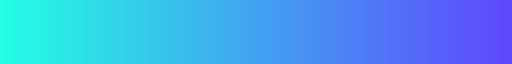

In [6]:
my_colors = ["#24FFE5", "#6047FF"]

my_cmap = sns.blend_palette(colors=my_colors, n_colors=3, as_cmap=True)
my_cmap

In [7]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Setup

In [9]:
%autoreload

var_id_order = [
    "age", "gender", "egfr", "spot_acr", "calc", "phos", "total_co2", "alb", 
    "diabetes", "pmh_hyper", "pmh_chf", "potassium", "measd_sbp"
]

var_order = [
    "Age", "Female Sex", "eGFR", "ACR", "Calcium", "Phosphate", "Bicarbonate", "Albumin", 
    "Diabetes", "Hypertension", "CHF", "Potassium", "Systolic BP"
]

vs = [
    ["spot_acr", "age", "egfr", "gender"],
    ["spot_acr", "age", "egfr", "gender", "alb", "phos", "calc", "total_co2"],
    ["diabetes", "pmh_hyper", "spot_acr", "age", "egfr", "gender", "alb", "phos", "calc", "total_co2"],
    ["diabetes", "pmh_hyper", "spot_acr", "age", "egfr", "gender", "alb", "phos", "calc", "total_co2", "potassium", "pmh_chf", "measd_sbp"]
]

predictor_sets = ["4V", "8V", "10V", "13V"]

dfs = ulib.preamble_ndt(df_toh_master, var_set=vs[-1], timeframes=[6, 12, 24], chop_easy=False, chop_end=False)

VARIABLES:  ['diabetes', 'pmh_hyper', 'spot_acr', 'age', 'egfr', 'gender', 'alb', 'phos', 'calc', 'total_co2', 'potassium', 'pmh_chf', 'measd_sbp']
~~~6~~~
0    12820
1     2026
2      873
3      581
Name: labelo, dtype: int64
0    13401
1     2899
Name: labeldial, dtype: int64
2432
~~~12~~~
0    10398
1     3328
2     1417
3     1157
Name: labelo, dtype: int64
0    11555
1     4745
Name: labeldial, dtype: int64
2432
~~~24~~~
0    7396
1    4858
2    2105
3    1941
Name: labelo, dtype: int64
0    9337
1    6963
Name: labeldial, dtype: int64
2432
0    14270
1     2030
Name: ex, dtype: int64
TRUNCATIONS: 
0    11779
1     2053
Name: truncdial, dtype: int64
0    14270
1     2030
Name: ex, dtype: int64
TRUNCATIONS: 
0    12069
1     1763
Name: truncdial, dtype: int64
0    14270
1     2030
Name: ex, dtype: int64
TRUNCATIONS: 
0    12249
1     1583
Name: truncdial, dtype: int64


In [10]:
labelnames = ["labeldial6", "labeldial12", "labeldial24"]
labeltimes = [6, 12, 24]
ttetype = "tteo"

df = dfs[24].copy()
df["labeldial6"] = dfs[6].labeldial
df["labeldial12"] = dfs[12].labeldial
df["labeldial24"] = df.labeldial

# dropping visits (and potentially patients) with no event (dialysis or death) and less than 24 months of FUP
df = df.loc[df.truncdial == 0].reset_index()

print(df.shape)
print(df[labelnames].sum())

(11793, 64)
labeldial6     2562
labeldial12    4265
labeldial24    6330
dtype: int64


# Cox Model HRs

## Fitting Standalone Cox Models on Entire Dataset

In [11]:
%autoreload

temp = df.copy()

hr_bs, hr_tvs = list(), list()
p_bs, p_tvs = list(), list()
ci_bs, ci_tvs = list(), list()

for v in vs:

    hr_b = pd.DataFrame(np.empty(shape=(1, len(v))), columns=v)
    hr_tv = pd.DataFrame(np.empty(shape=(1, len(v))), columns=v)
    p_b = pd.DataFrame(np.empty(shape=(1, len(v))), columns=v)
    p_tv = pd.DataFrame(np.empty(shape=(1, len(v))), columns=v)
    ci_b = pd.DataFrame(np.empty(shape=(1, len(v))), columns=v)
    ci_tv = pd.DataFrame(np.empty(shape=(1, len(v))), columns=v)
    
    ####### COX START #######
    # ~~~~~ SETUP ~~~~~ #
    # individuals baseline
    inds_b = temp.drop_duplicates(subset="pt_id", keep="first").reset_index(drop=True)

    data_b = inds_b[v].copy()
    means_b = data_b[v].mean()
    data_b[v] -= means_b

    data_b = pd.concat([data_b, inds_b[["censordial", "sa_time"]]], axis=1)
    data_b["censordial"] = (data_b.censordial == 0).astype(int)

    # time-varying
    data_tv = temp[v].copy()
    means_tv = data_tv[v].mean()
    data_tv[v] -= means_tv

    data_tv = pd.concat([data_tv, temp[["pt_id", "start", "stop", "event"]]], axis=1)

    # don't center categoricals like gender
    for v2 in v:
        if v2 in defs.cat_voi:
            data_b[v2] = inds_b[v2].copy()
            data_tv[v2] = temp[v2].copy()

    cph_b, cph_tv = ulib.dumb_code_greyout_fix(data_b, data_tv) # calls to lifelines.CoxPHFitter grey out any code under

    hr_b.iloc[0] = np.round(cph_b.summary["exp(coef)"][v].ravel(), 3)
    hr_tv.iloc[0] = np.round(cph_tv.summary["exp(coef)"][v].ravel(), 3)
    p_b.iloc[0] = np.round(cph_b.summary.p[v].ravel(), 3)
    p_tv.iloc[0] = np.round(cph_tv.summary.p[v].ravel(), 3)

    sb, stv = list(), list()
    lowsb, upsb = cph_b.summary["exp(coef) lower 95%"][v], cph_b.summary["exp(coef) upper 95%"][v]
    lowstv, upstv = cph_tv.summary["exp(coef) lower 95%"][v], cph_tv.summary["exp(coef) upper 95%"][v]

    for c in v:
        sb.append("({:.3f}, {:.3f})".format(lowsb[c], upsb[c]))
        stv.append("({:.3f}, {:.3f})".format(lowstv[c], upstv[c]))

    ci_b.iloc[0] = np.asarray(sb)
    ci_tv.iloc[0] = np.asarray(stv)

    hr_bs.append(hr_b)
    hr_tvs.append(hr_tv)
    p_bs.append(p_b)
    p_tvs.append(p_tv)
    ci_bs.append(ci_b)
    ci_tvs.append(ci_tv)

## Table S4

In [12]:
tvt = pd.melt(hr_bs[0], var_name="Predictor", value_name="HR")
tvt["Predictor Set"] = predictor_sets[0]

for tvi, tv in enumerate(hr_bs[1:]):
    newtv = pd.melt(tv, var_name="Predictor", value_name="HR")
    newtv["Predictor Set"] = predictor_sets[tvi + 1]
    
    tvt = pd.concat([tvt, newtv], axis=0)

t = pd.DataFrame(tvt).reset_index(drop=True)

t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]
tcols = t["HR"].columns.to_numpy()

b = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols, dtype=str,
)[predictor_sets]

tvt = pd.melt(ci_bs[0], var_name="Predictor", value_name="HR")
tvt["Predictor Set"] = predictor_sets[0]

for tvi, tv in enumerate(ci_bs[1:]):
    newtv = pd.melt(tv, var_name="Predictor", value_name="HR")
    newtv["Predictor Set"] = predictor_sets[tvi + 1]
    
    tvt = pd.concat([tvt, newtv], axis=0)

t = pd.DataFrame(tvt).reset_index(drop=True)

t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]
tcols = t["HR"].columns.to_numpy()

cib = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols, dtype=str,
)[predictor_sets]

for v in predictor_sets:
    b[v] = b[v].str.cat(" " + cib[v])
b

,4V,8V,10V,13V
Age,"0.977 (0.973, 0.981)","0.978 (0.974, 0.982)","0.976 (0.972, 0.980)","0.974 (0.970, 0.978)"
Female Sex,"0.776 (0.690, 0.874)","0.798 (0.707, 0.900)","0.802 (0.711, 0.905)","0.794 (0.703, 0.896)"
eGFR,"0.896 (0.886, 0.906)","0.906 (0.895, 0.917)","0.904 (0.893, 0.916)","0.902 (0.891, 0.914)"
ACR,"1.002 (1.002, 1.002)","1.001 (1.001, 1.002)","1.001 (1.001, 1.002)","1.001 (1.001, 1.002)"
Calcium,NaN,"0.439 (0.292, 0.661)","0.416 (0.276, 0.627)","0.455 (0.300, 0.689)"
Phosphate,NaN,"1.536 (1.256, 1.879)","1.452 (1.183, 1.782)","1.437 (1.169, 1.766)"
Total CO2,NaN,"0.987 (0.968, 1.006)","0.985 (0.966, 1.005)","0.98 (0.960, 1.000)"
Albumin,NaN,"0.98 (0.965, 0.995)","0.981 (0.966, 0.996)","0.976 (0.961, 0.991)"
Diabetes,NaN,NaN,"1.012 (0.893, 1.146)","0.976 (0.859, 1.108)"
Hypertension,NaN,NaN,"1.54 (1.231, 1.927)","1.477 (1.180, 1.850)"


In [13]:
tvt = pd.melt(p_bs[0], var_name="Predictor", value_name="HR")
tvt["Predictor Set"] = predictor_sets[0]

for tvi, tv in enumerate(p_bs[1:]):
    newtv = pd.melt(tv, var_name="Predictor", value_name="HR")
    newtv["Predictor Set"] = predictor_sets[tvi + 1]
    
    tvt = pd.concat([tvt, newtv], axis=0)

t = pd.DataFrame(tvt).reset_index(drop=True)

t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]
tcols = t["HR"].columns.to_numpy()

pb = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols, dtype=str,
)[predictor_sets]
pb

,4V,8V,10V,13V
Age,0.0,0.0,0.0,0.0
Female Sex,0.0,0.0,0.0,0.0
eGFR,0.0,0.0,0.0,0.0
ACR,0.0,0.0,0.0,0.0
Calcium,NaN,0.0,0.0,0.0
Phosphate,NaN,0.0,0.0,0.001
Total CO2,NaN,0.188,0.137,0.054
Albumin,NaN,0.009,0.013,0.002
Diabetes,NaN,NaN,0.857,0.704
Hypertension,NaN,NaN,0.0,0.001


## Table S5

In [14]:
tvt = pd.melt(hr_tvs[0], var_name="Predictor", value_name="HR")
tvt["Predictor Set"] = predictor_sets[0]

for tvi, tv in enumerate(hr_tvs[1:]):
    newtv = pd.melt(tv, var_name="Predictor", value_name="HR")
    newtv["Predictor Set"] = predictor_sets[tvi + 1]
    
    tvt = pd.concat([tvt, newtv], axis=0)

t = pd.DataFrame(tvt).reset_index(drop=True)

t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]
tcols = t["HR"].columns.to_numpy()

tvv = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols, dtype=str,
)[predictor_sets]

tvt = pd.melt(ci_tvs[0], var_name="Predictor", value_name="HR")
tvt["Predictor Set"] = predictor_sets[0]

for tvi, tv in enumerate(ci_tvs[1:]):
    newtv = pd.melt(tv, var_name="Predictor", value_name="HR")
    newtv["Predictor Set"] = predictor_sets[tvi + 1]
    
    tvt = pd.concat([tvt, newtv], axis=0)

t = pd.DataFrame(tvt).reset_index(drop=True)

t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]
tcols = t["HR"].columns.to_numpy()

citvv = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols, dtype=str,
)[predictor_sets]

for v in predictor_sets:
    tvv[v] = tvv[v].str.cat(" " + citvv[v])
tvv

,4V,8V,10V,13V
Age,"0.985 (0.981, 0.989)","0.985 (0.982, 0.989)","0.984 (0.980, 0.988)","0.982 (0.978, 0.986)"
Female Sex,"0.706 (0.627, 0.795)","0.72 (0.638, 0.811)","0.725 (0.643, 0.818)","0.728 (0.646, 0.822)"
eGFR,"0.683 (0.671, 0.696)","0.7 (0.685, 0.714)","0.697 (0.682, 0.712)","0.695 (0.681, 0.710)"
ACR,"1.001 (1.001, 1.001)","1.001 (1.001, 1.001)","1.001 (1.000, 1.001)","1.001 (1.000, 1.001)"
Calcium,NaN,"0.649 (0.463, 0.909)","0.644 (0.459, 0.904)","0.65 (0.462, 0.915)"
Phosphate,NaN,"1.592 (1.342, 1.889)","1.546 (1.301, 1.838)","1.537 (1.291, 1.829)"
Total CO2,NaN,"1.016 (0.997, 1.035)","1.012 (0.993, 1.032)","1.008 (0.989, 1.028)"
Albumin,NaN,"0.975 (0.963, 0.988)","0.975 (0.963, 0.987)","0.974 (0.961, 0.986)"
Diabetes,NaN,NaN,"1.136 (1.002, 1.288)","1.067 (0.938, 1.213)"
Hypertension,NaN,NaN,"1.351 (1.080, 1.692)","1.326 (1.058, 1.662)"


In [15]:
tvt = pd.melt(p_tvs[0], var_name="Predictor", value_name="HR")
tvt["Predictor Set"] = predictor_sets[0]

for tvi, tv in enumerate(p_tvs[1:]):
    newtv = pd.melt(tv, var_name="Predictor", value_name="HR")
    newtv["Predictor Set"] = predictor_sets[tvi + 1]
    
    tvt = pd.concat([tvt, newtv], axis=0)

t = pd.DataFrame(tvt).reset_index(drop=True)

t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]
tcols = t["HR"].columns.to_numpy()

ptvv = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols, dtype=str,
)[predictor_sets]
ptvv

,4V,8V,10V,13V
Age,0.0,0.0,0.0,0.0
Female Sex,0.0,0.0,0.0,0.0
eGFR,0.0,0.0,0.0,0.0
ACR,0.0,0.0,0.0,0.0
Calcium,NaN,0.012,0.011,0.014
Phosphate,NaN,0.0,0.0,0.0
Total CO2,NaN,0.092,0.204,0.401
Albumin,NaN,0.0,0.0,0.0
Diabetes,NaN,NaN,0.047,0.325
Hypertension,NaN,NaN,0.009,0.014


# ML Examination 1 (SHAP Plots)

Explaining the same 1000 random samples.

In [16]:
rng = default_rng()
sample_is = rng.choice(a=df.shape[0], size=1000, replace=False)

## Random Forest Classifier

In [17]:
rfc_shap_values = list()

for label in labelnames:
    temp_rfc_shap_values = list()

    for vi, var_set in enumerate(vs):

        classes_weights = {
            0: len(df[label]) / (2 * df[label].value_counts()[0]), 
            1: len(df[label]) / (2 * df[label].value_counts()[1])
        }

        rfc = RandomForestClassifier(
            max_depth=16, min_samples_leaf=8, min_samples_split=4, oob_score=True, n_estimators=500, class_weight=classes_weights, n_jobs=-1
        )
        print("Fitting...", end=""), 
        rfc.fit(df[var_set], df[label])

        print("Fitted")
        temp_rfc_shap_values.append((rfc, df[var_set].iloc[sample_is], df[label].iloc[sample_is]))
    
    rfc_shap_values.append(temp_rfc_shap_values)

Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted


### Figure S1

**4V**

In [18]:
%autoreload

fours = list()

for rfci, rfc in enumerate(rfc_shap_values):

    rfc = rfc[0]

    explainer = shap.TreeExplainer(rfc[0])
    shap_values = explainer.shap_values(rfc[1])

    fours.append([rfc, explainer, shap_values])

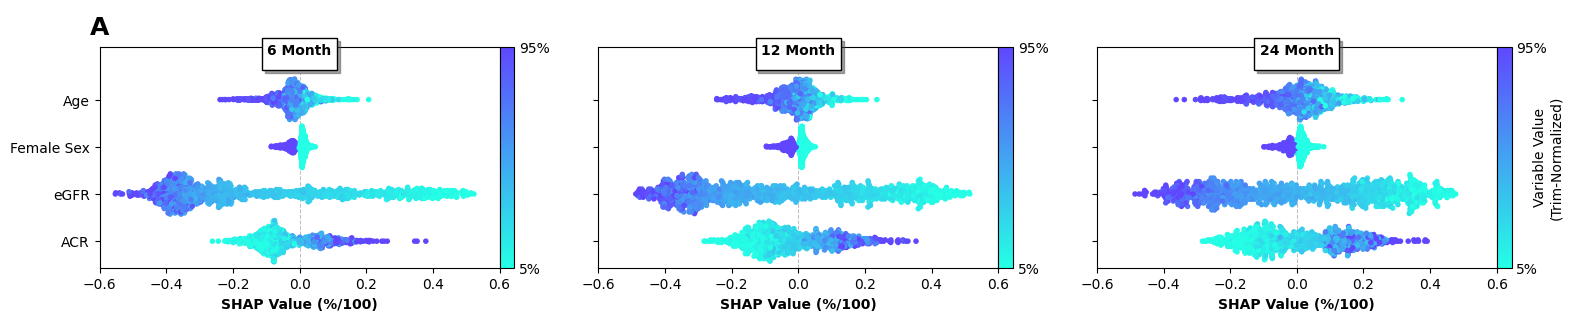

In [21]:
%autoreload
plt.style.use("default")
fig_height = 3

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)
months = ["6 Month", "12 Month", "24 Month"]

for rfci, (rfc, explainer, shap_values) in enumerate(fours):

    num_feats = shap_values[1].shape[1]

    for i in range(num_feats):

        feature_name = rfc[1].columns[i]

        # baseline (expected prediction) 
        bl = explainer.expected_value[1]

        # for treeexplainer
        d = shap_values[1][:,i]

        plib.my_shap_swarmplot(
            d, bl, rfc[1][feature_name].to_numpy(), defs.col_pretty_map[feature_name], feature_name in defs.cat_vars, my_cmap,
            pos=np.argwhere(np.asarray(var_id_order) == feature_name)[0][0], ax=plots[rfci], row_height=0.4, xlims=(-0.6, 0.6), xlabel="SHAP Value (%/100)"
        )
        
    plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
    plots[rfci].set_ylim(top=0.9, bottom=-2.85)

    plots[rfci].vlines(
        x=[0], ymin=-2.85, ymax=0.45, linestyles="dashed",
        color="black", **{"alpha":0.25, "linewidth":0.75}
    )

    leg = Legend(
        plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0.5, 1.07),
        ncol=2, fancybox=False, shadow=True, framealpha=1, columnspacing=0.8, handletextpad=0.5, 
        edgecolor="black",
        title="{}".format(months[rfci]), 
        title_fontproperties=dict(weight="bold")
    )
    plots[rfci].add_artist(leg)

    # will have to cut and paste the panel labels in
    if rfci == 0:
        leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.2), title="A", title_fontproperties=dict(weight="bold", size="18"), 
                    ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
        plots[rfci].add_artist(leg2)

    # only color bar on 24-monthers
    # going to splice these figures together
    m = cm.ScalarMappable(cmap=my_cmap)
    m.set_array([0, 1])
    cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=15 * (fig_height / 3))
    cb.set_ticklabels(["5%", "95%"])
    cb.ax.tick_params(length=0)
    cb.set_alpha(1)

    if rfci == 2:
        cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)
        
plt.tight_layout()
plt.show()

**8V**

In [22]:
%autoreload

eights = list()

for rfci, rfc in enumerate(rfc_shap_values):

    rfc = rfc[1]

    explainer = shap.TreeExplainer(rfc[0])
    shap_values = explainer.shap_values(rfc[1])

    eights.append([rfc, explainer, shap_values])

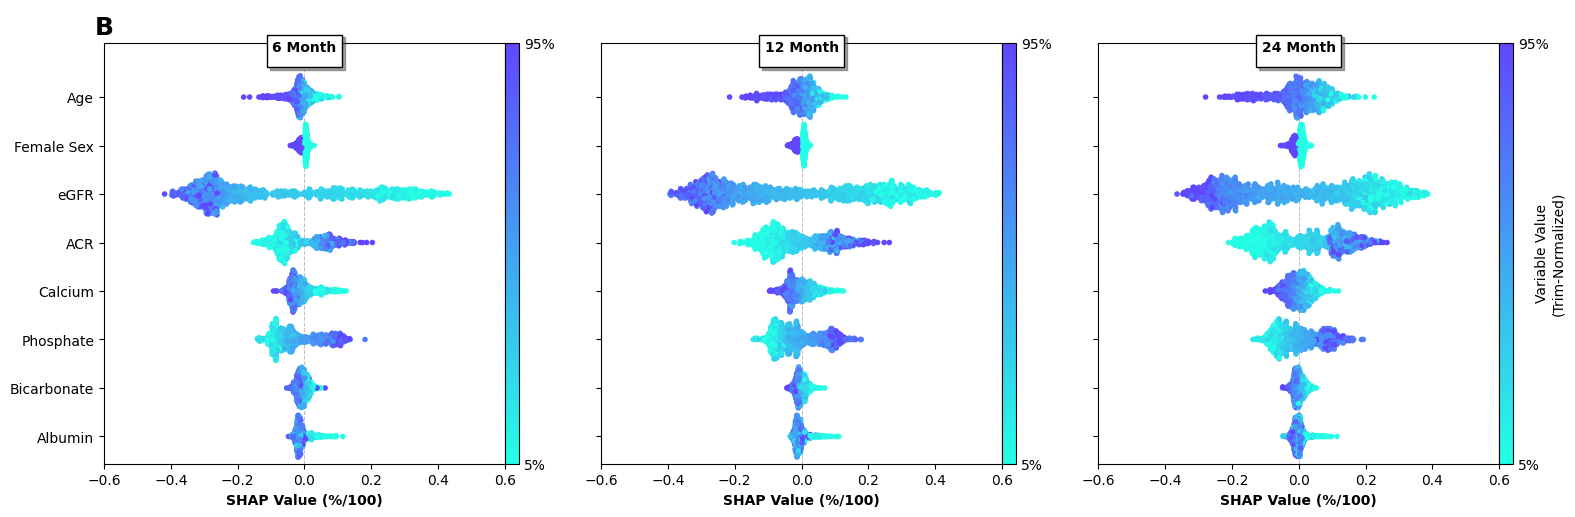

In [37]:
plt.style.use("default")
fig_height = 5

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)
months = ["6 Month", "12 Month", "24 Month"]

for rfci, (rfc, explainer, shap_values) in enumerate(eights):
    num_feats = shap_values[1].shape[1]
    
    for i in range(num_feats):

        feature_name = rfc[1].columns[i]

        # baseline (expected prediction) 
        bl = explainer.expected_value[1]

        # for treeexplainer
        d = shap_values[1][:,i]

        plib.my_shap_swarmplot(
            d, bl, rfc[1][feature_name].to_numpy(), defs.col_pretty_map[feature_name], feature_name in defs.cat_vars, my_cmap,
            pos=np.argwhere(np.asarray(var_id_order) == feature_name)[0][0], ax=plots[rfci], row_height=0.4, xlims=(-0.6, 0.6), xlabel="SHAP Value (%/100)"
        )
        
    plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
    plots[rfci].set_ylim(top=0.9, bottom=-6.05)

    plots[rfci].vlines(
        x=[0], ymin=-6.05, ymax=0.45, linestyles="dashed",
        color="black", **{"alpha":0.25, "linewidth":0.75}
    )

    leg = Legend(
        plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0.5, 1.035),
        ncol=2, fancybox=False, shadow=True, framealpha=1, columnspacing=0.8, handletextpad=0.5, 
        edgecolor="black",
        title="{}".format(months[rfci]), 
        title_fontproperties=dict(weight="bold")
    )
    plots[rfci].add_artist(leg)

    # will have to cut and paste the panel labels in
    if rfci == 0:
        leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.095), title="B", title_fontproperties=dict(weight="bold", size="18"), 
                    ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
        plots[rfci].add_artist(leg2)

    # only color bar on 24-monthers
    # going to splice these figures together
    m = cm.ScalarMappable(cmap=my_cmap)
    m.set_array([0, 1])
    cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=18 * (fig_height / 3))
    cb.set_ticklabels(["5%", "95%"])
    cb.ax.tick_params(length=0)
    cb.set_alpha(1)

    if rfci == 2:
        cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)

plt.tight_layout()
plt.show()

**10V**

In [24]:
%autoreload

tens = list()

for rfci, rfc in enumerate(rfc_shap_values):

    rfc = rfc[2]

    explainer = shap.TreeExplainer(rfc[0])
    shap_values = explainer.shap_values(rfc[1])

    tens.append([rfc, explainer, shap_values])

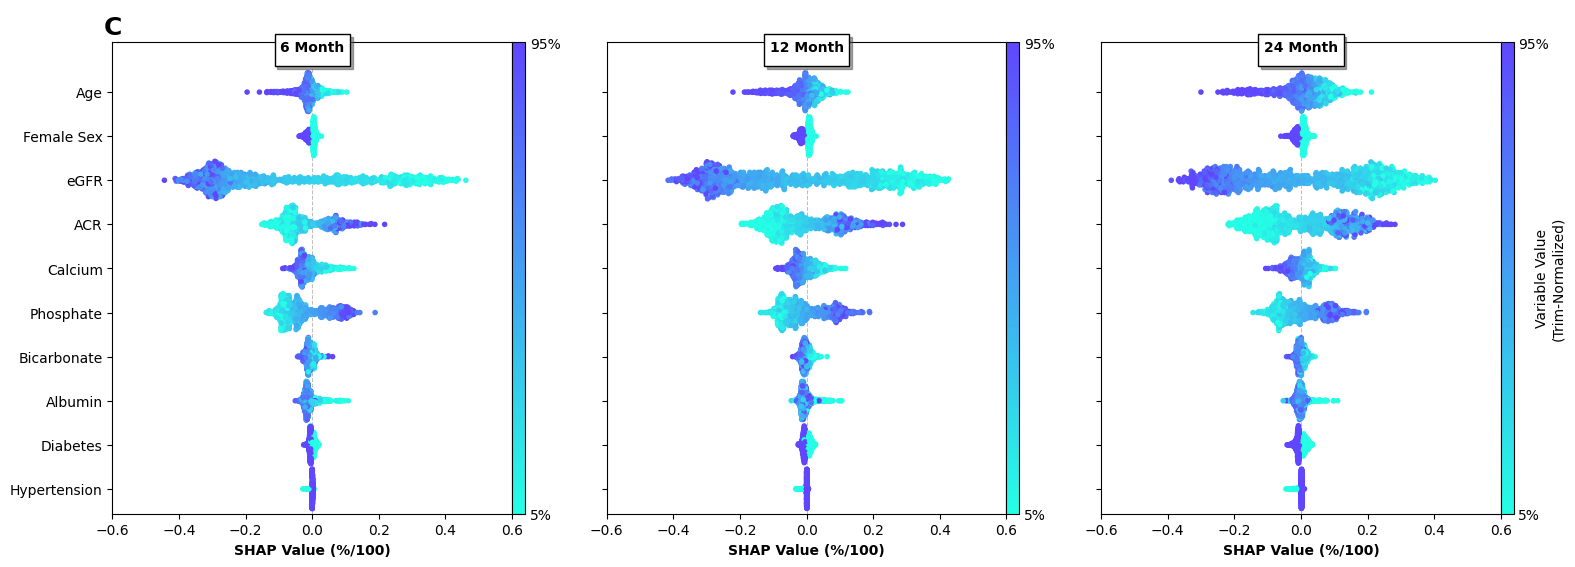

In [38]:
plt.style.use("default")
fig_height = 5.5

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)
months = ["6 Month", "12 Month", "24 Month"]
        

for rfci, (rfc, explainer, shap_values) in enumerate(tens):
    num_feats = shap_values[1].shape[1]

    for i in range(num_feats):

        feature_name = rfc[1].columns[i]

        # baseline (expected prediction) 
        bl = explainer.expected_value[1]

        # for treeexplainer
        d = shap_values[1][:,i]

        plib.my_shap_swarmplot(
            d, bl, rfc[1][feature_name].to_numpy(), defs.col_pretty_map[feature_name], feature_name in defs.cat_vars, my_cmap,
            pos=np.argwhere(np.asarray(var_id_order) == feature_name)[0][0], ax=plots[rfci], row_height=0.4, xlims=(-0.6, 0.6), xlabel="SHAP Value (%/100)"
        )
        
    plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
    plots[rfci].set_ylim(top=0.9, bottom=-7.65)

    plots[rfci].vlines(
        x=[0], ymin=-7.65, ymax=0.45, linestyles="dashed",
        color="black", **{"alpha":0.25, "linewidth":0.75}
    )

    leg = Legend(
        plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0.5, 1.032),
        ncol=2, fancybox=False, shadow=True, framealpha=1, columnspacing=0.8, handletextpad=0.5, 
        edgecolor="black",
        title="{}".format(months[rfci]), 
        title_fontproperties=dict(weight="bold")
    )
    plots[rfci].add_artist(leg)

    # will have to cut and paste the panel labels in
    if rfci == 0:
        leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.085), title="C", title_fontproperties=dict(weight="bold", size="18"), 
                    ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
        plots[rfci].add_artist(leg2)

    # only color bar on 24-monthers
    # going to splice these figures together
    m = cm.ScalarMappable(cmap=my_cmap)
    m.set_array([0, 1])
    cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=20 * (fig_height / 3))
    cb.set_ticklabels(["5%", "95%"])
    cb.ax.tick_params(length=0)
    cb.set_alpha(1)

    if rfci == 2:
        cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)
plt.tight_layout()
plt.show()

**13V**

In [26]:
%autoreload

thirteens = list()

for rfci, rfc in enumerate(rfc_shap_values):

    rfc = rfc[3]

    explainer = shap.TreeExplainer(rfc[0])
    shap_values = explainer.shap_values(rfc[1])

    thirteens.append([rfc, explainer, shap_values])

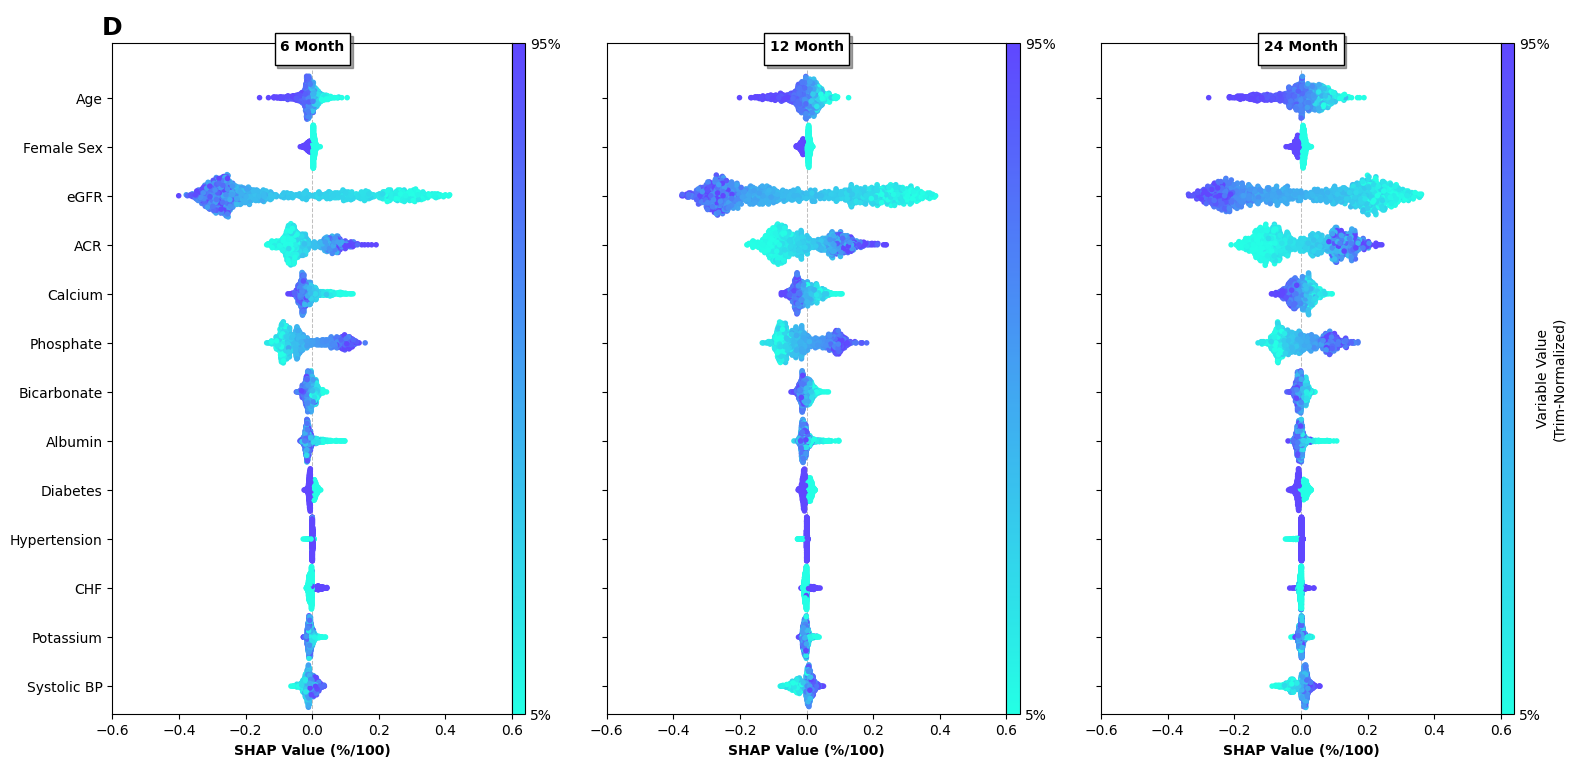

In [46]:
plt.style.use("default")
fig_height = 7.5

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)
months = ["6 Month", "12 Month", "24 Month"]

for rfci, (rfc, explainer, shap_values) in enumerate(thirteens):

    num_feats = shap_values[1].shape[1]
    
    for i in range(num_feats):

        feature_name = rfc[1].columns[i]

        # baseline (expected prediction) 
        bl = explainer.expected_value[1]

        # for treeexplainer
        d = shap_values[1][:,i]

        plib.my_shap_swarmplot(
            d, bl, rfc[1][feature_name].to_numpy(), defs.col_pretty_map[feature_name], feature_name in defs.cat_vars, my_cmap,
            pos=np.argwhere(np.asarray(var_id_order) == feature_name)[0][0], ax=plots[rfci], row_height=0.4, xlims=(-0.6, 0.6), xlabel="SHAP Value (%/100)"
        )
        
    plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
    plots[rfci].set_ylim(top=0.9, bottom=-10.05)

    plots[rfci].vlines(
        x=[0], ymin=-10.05, ymax=0.45, linestyles="dashed",
        color="black", **{"alpha":0.25, "linewidth":0.75}
    )

    leg = Legend(
        plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0.5, 1.024),
        ncol=2, fancybox=False, shadow=True, framealpha=1, columnspacing=0.8, handletextpad=0.5, 
        edgecolor="black",
        title="{}".format(months[rfci]), 
        title_fontproperties=dict(weight="bold")
    )
    plots[rfci].add_artist(leg)

    # will have to cut and paste the panel labels in
    if rfci == 0:
        leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.06), title="D", title_fontproperties=dict(weight="bold", size="18"), 
                    ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
        plots[rfci].add_artist(leg2)

    # only color bar on 24-monthers
    # going to splice these figures together
    m = cm.ScalarMappable(cmap=my_cmap)
    m.set_array([0, 1])
    cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=20 * (fig_height / 3))
    cb.set_ticklabels(["5%", "95%"])
    cb.ax.tick_params(length=0)
    cb.set_alpha(1)

    if rfci == 2:
        cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)
plt.tight_layout()
plt.show()

## Random Survival Forest

In [29]:
rsf_shap_values = list()

for label in labelnames:
    temp_rsf_shap_values = list()

    for vi, var_set in enumerate(vs):

        rsf = RandomSurvivalForest(
            max_depth=16, min_samples_leaf=8, min_samples_split=4, oob_score=True, n_estimators=500, n_jobs=-1
        )
        print("Fitting...", end=""), 
        # make format for sksurv (list of tuples: (censor, sa_time))
        inds_rsf = df.drop_duplicates(subset="pt_id", keep="first").reset_index(drop=True)
        x_rsf = inds_rsf[var_set].rename(columns=defs.col_pretty_map).copy()
        y_rsf = ulib.format_for_sksurv(inds_rsf[["censordial", "sa_time"]])

        rsf.fit(x_rsf, y_rsf)

        print("Fitted")
        temp_rsf_shap_values.append((
            rsf, df[var_set].iloc[sample_is].rename(columns=defs.col_pretty_map), 
            df[label].iloc[sample_is]
        ))
    
    rsf_shap_values.append(temp_rsf_shap_values)

Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted


### Figure S2

**4V Risk Score**

In [30]:
rsf4 = rsf_shap_values[0][0]

explainer4 = shap.Explainer(rsf4[0].predict, rsf4[1].iloc[:100])
shap_values4 = explainer4(rsf4[1].iloc[:100])

Exact explainer: 101it [03:17,  2.07s/it]                         


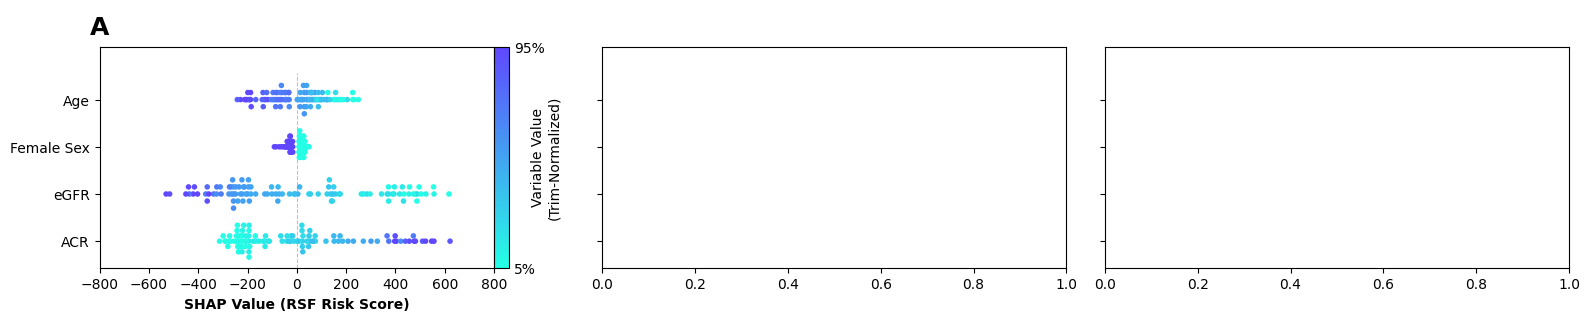

In [31]:
plt.style.use("default")
fig_height = 3

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)
rfci = 0

num_feats = shap_values4.values.shape[1]

for i in range(num_feats):

    feature_name = rsf4[1].columns[i]

    # baseline (expected prediction) 
    bl = 0

    # for treeexplainer
    d = shap_values4.values[:,i]

    plib.my_shap_swarmplot(
        d, bl, rsf4[1][feature_name].to_numpy(), feature_name, feature_name in defs.cat_vars, my_cmap,
        pos=np.argwhere(np.asarray(var_order) == feature_name)[0][0], ax=plots[rfci], row_height=0.4, xlims=(-800, 800), xlabel="SHAP Value (RSF Risk Score)"
    )
    
plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
plots[rfci].set_ylim(top=0.9, bottom=-2.85)

plots[rfci].vlines(
    x=[0], ymin=-2.85, ymax=0.45, linestyles="dashed",
    color="black", **{"alpha":0.25, "linewidth":0.75}
)

# will have to cut and paste the panel labels in
if rfci == 0:
    leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.2), title="A", title_fontproperties=dict(weight="bold", size="18"), 
                ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
    plots[rfci].add_artist(leg2)

# only color bar on 24-monthers
# going to splice these figures together
m = cm.ScalarMappable(cmap=my_cmap)
m.set_array([0, 1])
cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=15 * (fig_height / 3))
cb.set_ticklabels(["5%", "95%"])
cb.ax.tick_params(length=0)
cb.set_alpha(1)

if rfci == 0:
    cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)

plt.tight_layout()
plt.show()

**8V Risk Score**

In [32]:
rsf8 = rsf_shap_values[0][1]

explainer8 = shap.Explainer(rsf8[0].predict, rsf8[1].iloc[:100])
shap_values8 = explainer8(rsf8[1].iloc[:100])

Exact explainer: 101it [41:01, 24.62s/it]                         


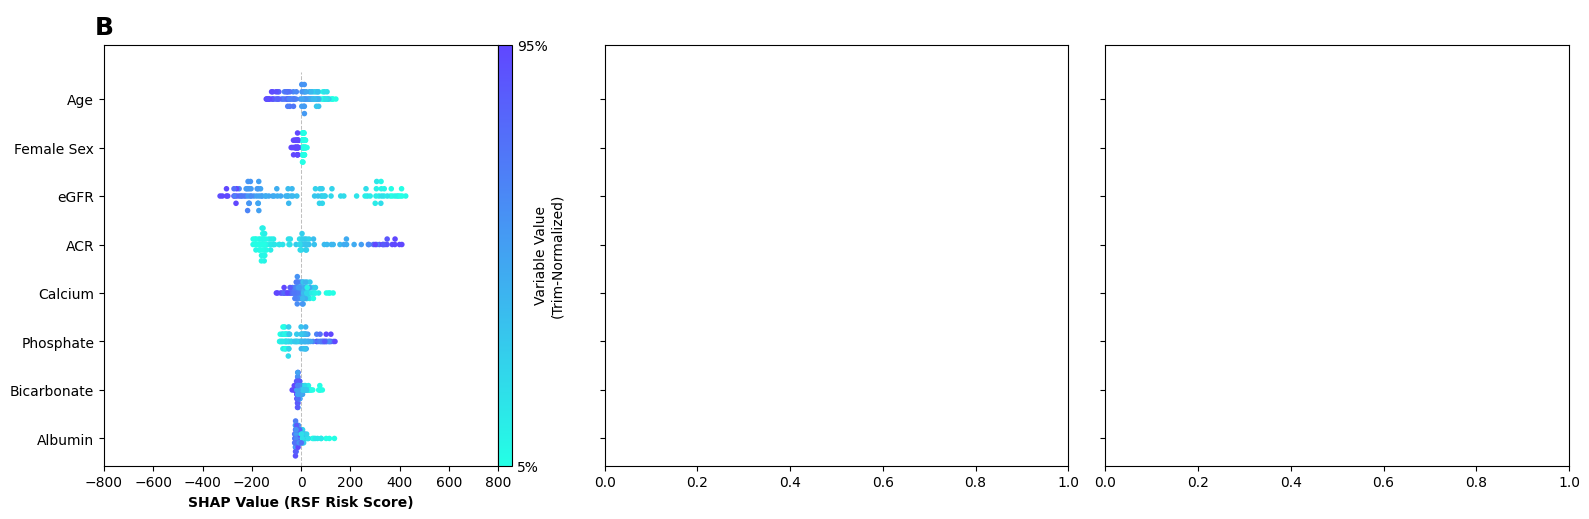

In [40]:
plt.style.use("default")
fig_height = 5

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)

panel_letters = ["A", "B", "C"]
rfci = 0

num_feats = shap_values8.values.shape[1]

for i in range(num_feats):

    feature_name = rsf8[1].columns[i]

    # baseline (expected prediction) 
    bl = 0

    # for treeexplainer
    d = shap_values8.values[:,i]

    plib.my_shap_swarmplot(
        d, bl, rsf8[1][feature_name].to_numpy(), feature_name, feature_name in defs.cat_vars, my_cmap,
        pos=np.argwhere(np.asarray(var_order) == feature_name)[0][0], ax=plots[rfci], row_height=0.4, xlims=(-800, 800), xlabel="SHAP Value (RSF Risk Score)"
    )
    
plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
plots[rfci].set_ylim(top=0.9, bottom=-6.05)

plots[rfci].vlines(
    x=[0], ymin=-6.05, ymax=0.45, linestyles="dashed",
    color="black", **{"alpha":0.25, "linewidth":0.75}
)

# will have to cut and paste the panel labels in
if rfci == 0:
    leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.1), title="B", title_fontproperties=dict(weight="bold", size="18"), 
                ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
    plots[rfci].add_artist(leg2)

# only color bar on 24-monthers
# going to splice these figures together
m = cm.ScalarMappable(cmap=my_cmap)
m.set_array([0, 1])
cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=18 * (fig_height / 3))
cb.set_ticklabels(["5%", "95%"])
cb.ax.tick_params(length=0)
cb.set_alpha(1)

if rfci == 0:
    cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)

plt.tight_layout()
plt.show()

**10V Risk Score**

In [48]:
rsf10 = rsf_shap_values[0][2]

explainer10 = shap.Explainer(rsf10[0].predict, rsf10[1].iloc[:100])
shap_values10 = explainer10(rsf10[1].iloc[:100])

Exact explainer: 101it [2:19:14, 83.54s/it]                          


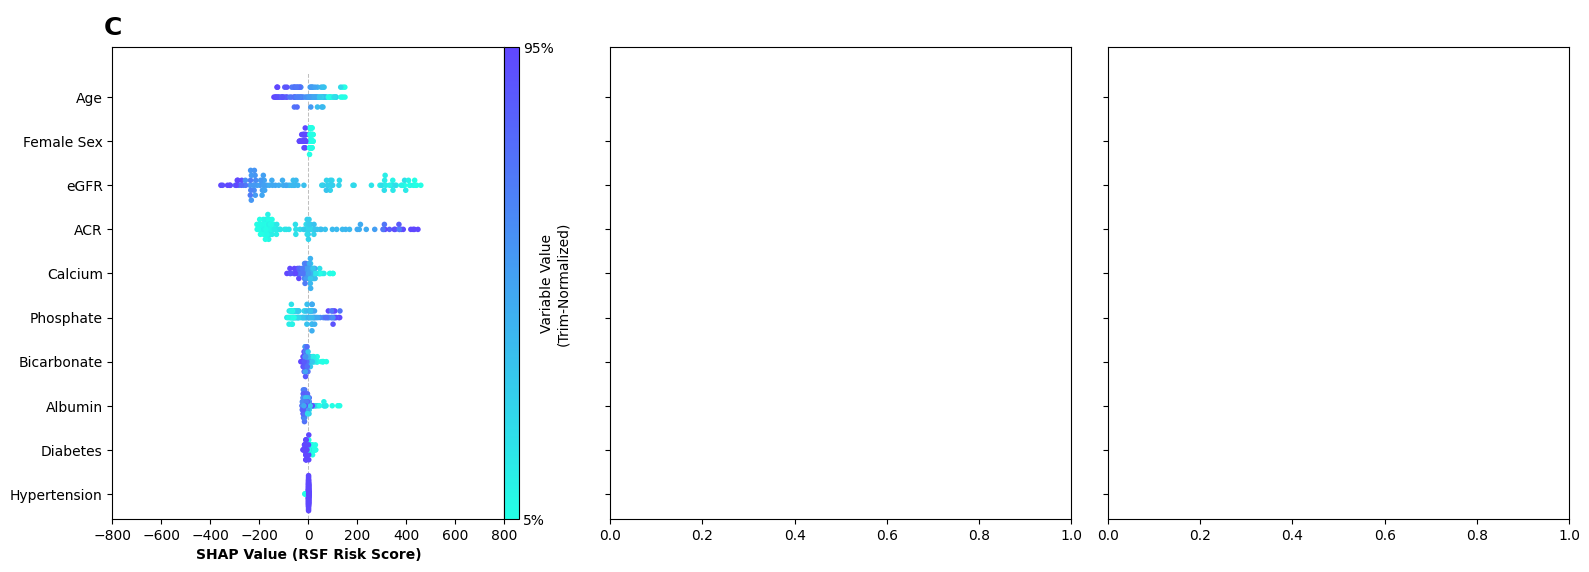

In [49]:
plt.style.use("default")
fig_height = 5.5

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)

panel_letters = ["A", "B", "C"]
months = ["6 Month", "12 Month", "24 Month"]
rfci = 0

num_feats = shap_values10.values.shape[1]

for i in range(num_feats):

    feature_name = rsf10[1].columns[i]

    # baseline (expected prediction) 
    bl = 0

    # for treeexplainer
    d = shap_values10.values[:,i]

    plib.my_shap_swarmplot(
        d, bl, rsf10[1][feature_name].to_numpy(), feature_name, feature_name in defs.cat_vars, my_cmap,
        pos=np.argwhere(np.asarray(var_order) == feature_name)[0][0], ax=plots[rfci], row_height=0.4, xlims=(-800, 800), xlabel="SHAP Value (RSF Risk Score)"
    )
    
plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
plots[rfci].set_ylim(top=0.9, bottom=-7.65)

plots[rfci].vlines(
    x=[0], ymin=-7.65, ymax=0.45, linestyles="dashed",
    color="black", **{"alpha":0.25, "linewidth":0.75}
)

if rfci == 0:
    leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.095), title="C", title_fontproperties=dict(weight="bold", size="18"), 
                ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
    plots[rfci].add_artist(leg2)

# only color bar on 24-monthers
# going to splice these figures together
m = cm.ScalarMappable(cmap=my_cmap)
m.set_array([0, 1])
cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=18 * (fig_height / 3))
cb.set_ticklabels(["5%", "95%"])
cb.ax.tick_params(length=0)
cb.set_alpha(1)

if rfci == 0:
    cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)

plt.tight_layout()
plt.show()

**13V Risk Score**

In [41]:
rsf13 = rsf_shap_values[0][3]

explainer13 = shap.Explainer(rsf13[0].predict, rsf13[1].iloc[:100])
shap_values13 = explainer13(rsf13[1].iloc[:100])

Permutation explainer: 101it [1:12:46, 43.66s/it]                         


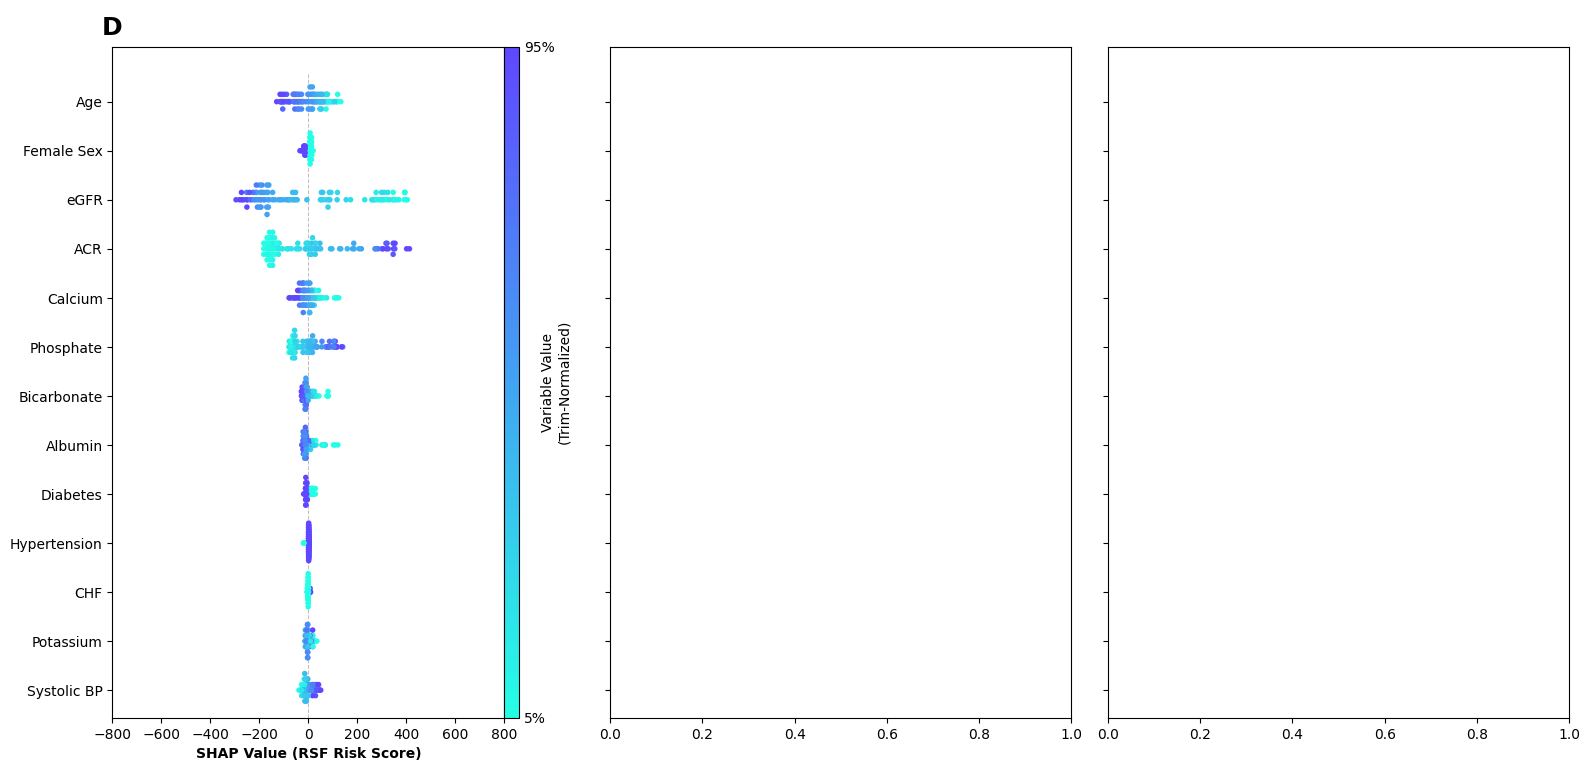

In [47]:
plt.style.use("default")
fig_height = 7.5

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)
rfci = 0

num_feats = shap_values13.values.shape[1]

for i in range(num_feats):

    feature_name = rsf13[1].columns[i]

    # baseline (expected prediction) 
    bl = 0

    # for treeexplainer
    d = shap_values13.values[:,i]

    plib.my_shap_swarmplot(
        d, bl, rsf13[1][feature_name].to_numpy(), feature_name, feature_name in defs.cat_vars, my_cmap,
        pos=np.argwhere(
            np.asarray(var_order) == ("CHF" if feature_name == "Congestive Heart Failure" else feature_name)
        )[0][0], ax=plots[rfci], row_height=0.4, xlims=(-800, 800), xlabel="SHAP Value (RSF Risk Score)"
    )
    
plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
plots[rfci].set_ylim(top=0.9, bottom=-10.05)

plots[rfci].vlines(
    x=[0], ymin=-10.05, ymax=0.45, linestyles="dashed",
    color="black", **{"alpha":0.25, "linewidth":0.75}
)

# will have to cut and paste the panel labels in
if rfci == 0:
    leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.065), title="D", title_fontproperties=dict(weight="bold", size="18"), 
                ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
    plots[rfci].add_artist(leg2)

# only color bar on 24-monthers
# going to splice these figures together
m = cm.ScalarMappable(cmap=my_cmap)
m.set_array([0, 1])
cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=18 * (fig_height / 3))
cb.set_ticklabels(["5%", "95%"])
cb.ax.tick_params(length=0)
cb.set_alpha(1)

if rfci == 0:
    cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)

plt.tight_layout()
plt.show()